In [1]:
from preprocessing import load_reviews
from concepts import ConceptExtractor, conceptualize_df, visualize_concept_wordcloud
from experiments import run_experiment
from features import SentimentFeatures
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random

[nltk_data] Downloading package punkt to /home/janek/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
2025-11-27 21:58:52.865162: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Setup

In [2]:
num_concepts = 10000
num_important_features = int(num_concepts * 0.2)

seed = 42

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
train_df, test_df, val_df = load_reviews("word", seed)

INFO:absl:No config specified, defaulting to config: imdb_reviews/plain_text
INFO:absl:Load dataset info from /home/janek/tensorflow_datasets/imdb_reviews/plain_text/1.0.0
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /home/janek/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.
I0000 00:00:1764277136.978785   30401 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3584 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
INFO:absl:Constructing tf.data.Dataset imdb_reviews for split train, from /home/janek/tensorflow_datasets/imdb_reviews/plain_text/1.0.0
INFO:absl:No config specified, defaulting to config: imdb_reviews/plain_text
INFO:absl:Load dataset info from /home/janek/tensorflow_datasets/imdb_reviews/plain_text/1.0.0
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /home/janek/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.
IN

,review,sentiment,units
0,This was an absolutely terrible movie. Don't b...,0,"[this, was, an, absolutely, terrible, movie, d..."
1,"I have been known to fall asleep during films,...",0,"[i, have, been, known, to, fall, asleep, durin..."
2,Mann photographs the Alberta Rocky Mountains i...,0,"[mann, photographs, the, alberta, rocky, mount..."
3,This is the kind of film for a snowy Sunday af...,1,"[this, is, the, kind, of, film, for, a, snowy,..."
4,"As others have mentioned, all the women that g...",1,"[as, others, have, mentioned, all, the, women,..."


# Concepts

In [4]:
extractor = ConceptExtractor()
concepts = extractor.train_concepts(train_df["units"].explode().tolist() , num_concepts)

INFO:concepts:Using device: cuda
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda:0
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2
INFO:concepts:Found 74127 unique units.
INFO:concepts:Computing embeddings...


Batches:   0%|          | 0/73 [00:00<?, ?it/s]

INFO:concepts:Clustering 74127 embeddings into 10000 concepts using FAISS...
WARNING clustering 74127 points to 10000 centroids: please provide at least 390000 training points


Clustering 74127 points in 384D to 10000 clusters, redo 1 times, 25 iterations
  Preprocessing in 0.01 s
  Iteration 24 (3.09 s, search 2.76 s): objective=24166.4 imbalance=1.442 nsplit=0       


INFO:concepts:Concept training completed!


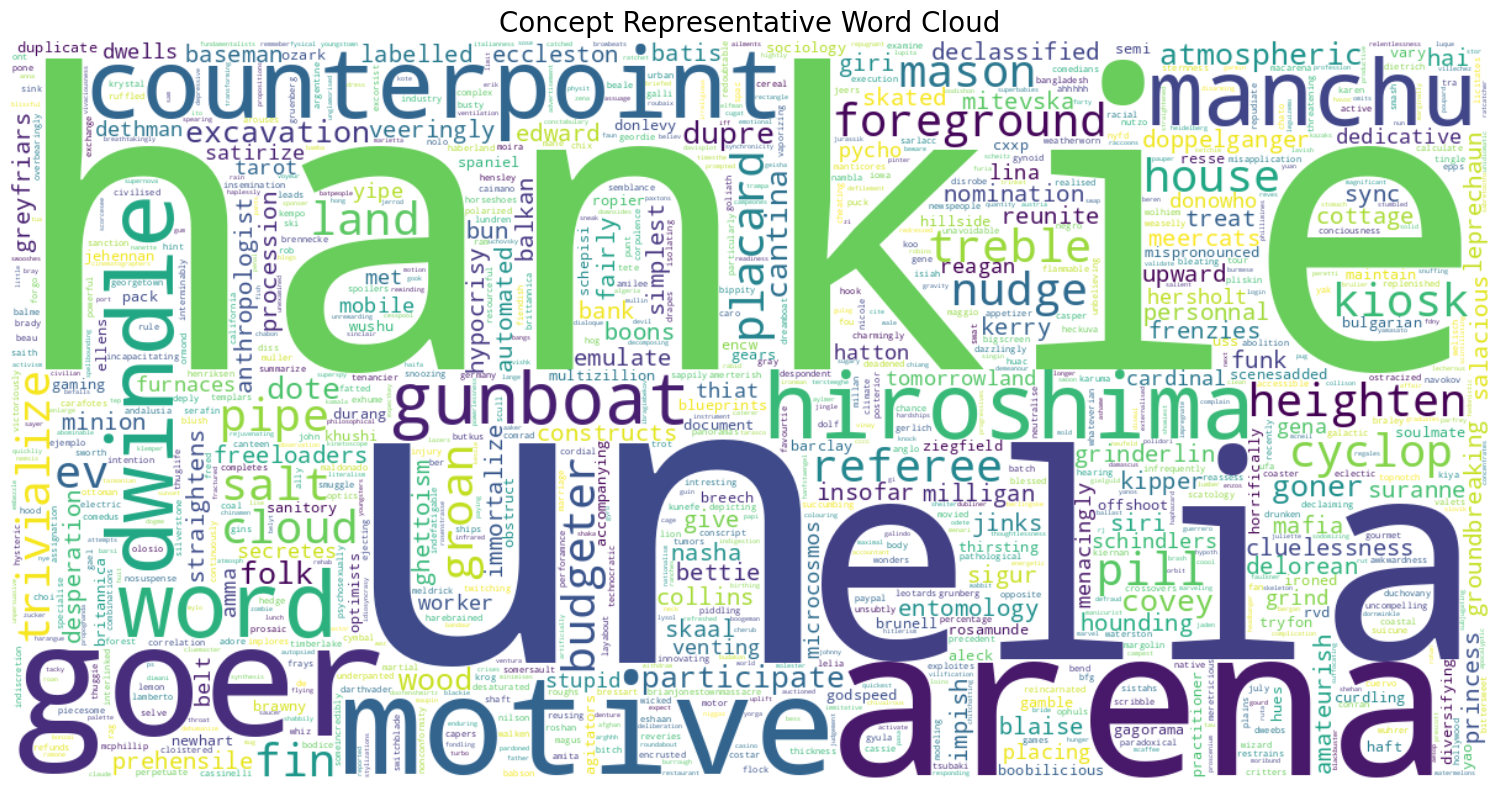

In [5]:
visualize_concept_wordcloud(concepts["concept_units"], num_concepts)

In [6]:
conceptualize_df(train_df, "units", concepts["unit_to_cluster"])
train_df.head()

,review,sentiment,units,concept_ids
0,This was an absolutely terrible movie. Don't b...,0,"[this, was, an, absolutely, terrible, movie, d...","[7360, 311, 1777, 9372, 5850, 1798, 5384, 917,..."
1,"I have been known to fall asleep during films,...",0,"[i, have, been, known, to, fall, asleep, durin...","[2925, 4479, 6724, 404, 9845, 3514, 9424, 3844..."
2,Mann photographs the Alberta Rocky Mountains i...,0,"[mann, photographs, the, alberta, rocky, mount...","[5251, 2647, 9711, 6840, 5259, 6607, 5781, 177..."
3,This is the kind of film for a snowy Sunday af...,1,"[this, is, the, kind, of, film, for, a, snowy,...","[7360, 311, 9711, 4137, 9199, 4858, 9199, 1777..."
4,"As others have mentioned, all the women that g...",1,"[as, others, have, mentioned, all, the, women,...","[8882, 4653, 4479, 8869, 6135, 9711, 9969, 206..."


In [7]:
# Map test words
test_unit_map = extractor.map_units_to_clusters(train_df["units"].explode().tolist(), concepts["cluster_centers"])

INFO:concepts:Mapping 74127 units to nearest clusters...


Batches:   0%|          | 0/73 [00:00<?, ?it/s]

In [8]:
conceptualize_df(test_df, "units", test_unit_map)
test_df.head()

,review,sentiment,units,concept_ids
15072,The latest film by the Spanish director Agusti...,1,"[the, latest, film, by, the, spanish, director...","[9711, 235, 4858, 9881, 9711, 6998, 557, 3362,..."
9987,"As others have mentioned, this movie is simila...",0,"[as, others, have, mentioned, this, movie, is,...","[8882, 4653, 4479, 8869, 1276, 1798, 311, 1108..."
24558,"I have no idea how to describe this movie, and...",1,"[i, have, no, idea, how, to, describe, this, m...","[2925, 4479, 917, 1417, 6289, 9845, 1994, 1276..."
2571,"Ah, I loved this movie. I think it had it all....",1,"[ah, i, loved, this, movie, i, think, it, had,...","[8028, 2925, 2795, 1276, 1798, 2925, 6880, 127..."
16059,Brilliant movie. The drawings were just amazin...,1,"[brilliant, movie, the, drawings, were, just, ...","[3999, 1798, 9711, 3798, 7364, 6774, 3999, 586..."


# Feature selection

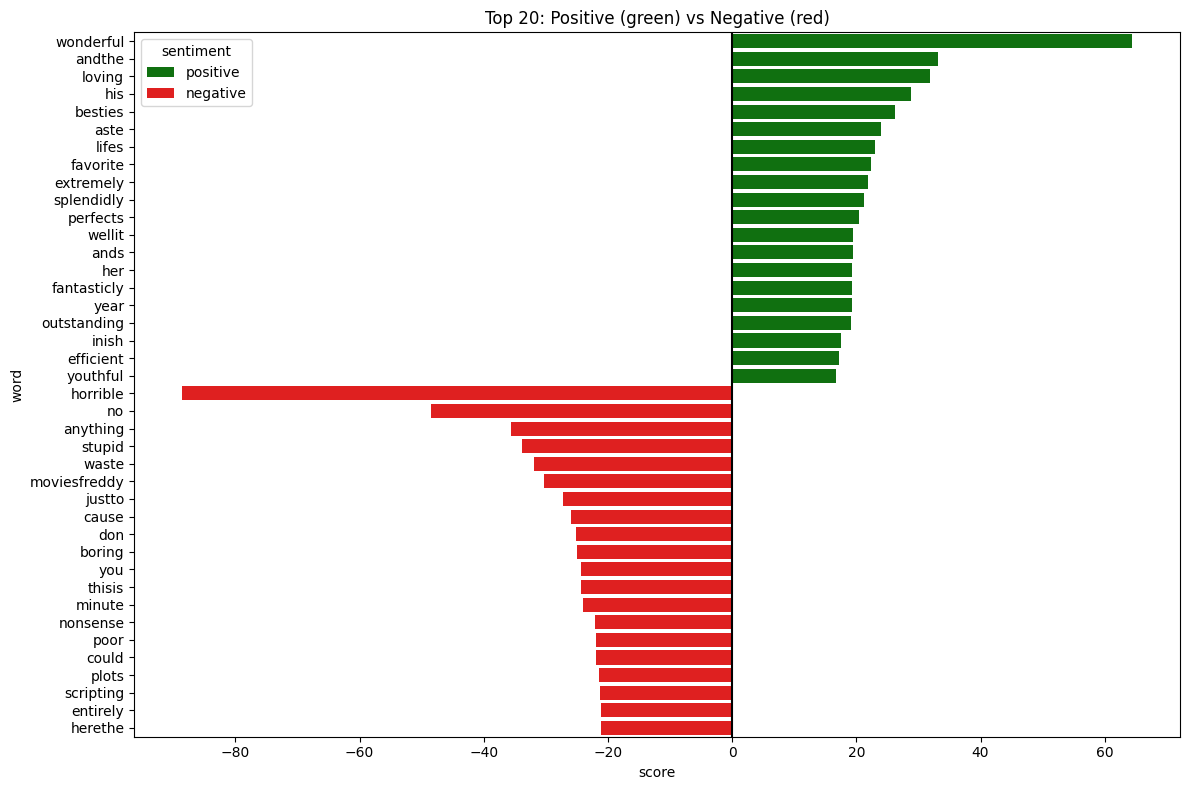

In [9]:
an = SentimentFeatures()
an.fit(train_df["concept_ids"], train_df["sentiment"])

an.plot_top(concepts["concept_units"])

In [10]:
train_df = an.add_top_features(train_df, n=num_important_features)
test_df  = an.add_top_features(test_df, n=num_important_features)

# Models

In [11]:
train_df.head(2000)

,review,sentiment,units,concept_ids,concept_ids_positive_features,concept_ids_negative_features,concept_ids_important_features
0,This was an absolutely terrible movie. Don't b...,0,"[this, was, an, absolutely, terrible, movie, d...","[7360, 311, 1777, 9372, 5850, 1798, 5384, 917,...","[1777, 5781, 9881, 5174, 6203, 1954, 3999, 774...","[7360, 311, 9372, 5850, 1798, 5384, 917, 3804,...","[7360, 311, 1777, 9372, 5850, 1798, 5384, 917,..."
1,"I have been known to fall asleep during films,...",0,"[i, have, been, known, to, fall, asleep, durin...","[2925, 4479, 6724, 404, 9845, 3514, 9424, 3844...","[3844, 4858, 1777, 463, 9199, 9943, 5785, 3879...","[2925, 4479, 6724, 404, 9845, 3514, 9424, 1519...","[2925, 4479, 6724, 404, 9845, 3514, 9424, 3844..."
2,Mann photographs the Alberta Rocky Mountains i...,0,"[mann, photographs, the, alberta, rocky, mount...","[5251, 2647, 9711, 6840, 5259, 6607, 5781, 177...","[5251, 2647, 9711, 5259, 6607, 5781, 1777, 238...","[4, 8566, 3843, 9845, 5384, 1519, 5170, 3456, ...","[5251, 2647, 9711, 5259, 6607, 5781, 1777, 238..."
3,This is the kind of film for a snowy Sunday af...,1,"[this, is, the, kind, of, film, for, a, snowy,...","[7360, 311, 9711, 4137, 9199, 4858, 9199, 1777...","[9711, 9199, 4858, 9199, 1777, 4522, 2134, 384...","[7360, 311, 4137, 8149, 4255, 2612, 1276, 2925...","[7360, 311, 9711, 4137, 9199, 4858, 9199, 1777..."
4,"As others have mentioned, all the women that g...",1,"[as, others, have, mentioned, all, the, women,...","[8882, 4653, 4479, 8869, 6135, 9711, 9969, 206...","[8882, 4653, 9711, 5781, 4858, 4827, 9711, 365...","[4479, 8869, 6135, 2061, 2612, 4341, 7360, 311...","[8882, 4653, 4479, 8869, 6135, 9711, 2061, 261..."
...,...,...,...,...,...,...,...
1995,I turn on 700 Club once in awhile and only agr...,0,"[i, turn, on, club, once, in, awhile, and, onl...","[2925, 7706, 5170, 3851, 8814, 5781, 7877, 578...","[5781, 7877, 5785, 5999, 6247, 9199, 9711, 919...","[2925, 7706, 5170, 8814, 917, 3451, 713, 4246,...","[2925, 7706, 5170, 8814, 5781, 7877, 5785, 917..."
1996,"Something about ""Paulie"" touched my heart as f...",1,"[something, about, paulie, touched, my, heart,...","[8838, 9199, 3611, 9861, 8010, 1881, 8882, 768...","[9199, 3611, 9861, 8010, 1881, 8882, 1777, 128...","[8838, 7680, 3520, 5384, 1276, 311, 1798, 2925...","[8838, 9199, 3611, 9861, 8010, 1881, 8882, 768..."
1997,This Hitchcock movie bears little similarity t...,0,"[this, hitchcock, movie, bears, little, simila...","[7360, 6532, 1798, 9402, 668, 4706, 9845, 8010...","[6532, 9402, 668, 8010, 9697, 4858, 5785, 1777...","[7360, 1798, 9845, 9372, 4542, 4542, 7314, 960...","[7360, 6532, 1798, 9402, 668, 9845, 8010, 9697..."
1998,"What's inexplicable? Firstly, the hatred towar...",1,"[what, is, inexplicable, firstly, the, hatred,...","[1330, 311, 4206, 1384, 9711, 6019, 5331, 7360...","[9711, 5331, 3006, 9711, 8589, 9199, 728, 1777...","[1330, 311, 4206, 6019, 7360, 1798, 1276, 917,...","[1330, 311, 4206, 9711, 6019, 5331, 7360, 1798..."


# Word Sequences

In [12]:
# Median number of concepts per review
median_all = int(train_df["concept_ids"].apply(len).median())
median_pos = int(train_df["concept_ids_positive_features"].apply(len).median())
median_neg = int(train_df["concept_ids_negative_features"].apply(len).median())
median_imp = int(train_df["concept_ids_important_features"].apply(len).median())

print(f"Median concepts per review: all={median_all}, positive={median_pos}, negative={median_neg}, important={median_imp}")

Median concepts per review: all=177, positive=71, negative=84, important=153


In [13]:
# --- Prepare datasets ---
X_all_train = pad_sequences(train_df["concept_ids"], maxlen=median_all, padding='post')
X_pos_train = pad_sequences(train_df["concept_ids_positive_features"], maxlen=median_pos, padding='post')
X_neg_train = pad_sequences(train_df["concept_ids_negative_features"], maxlen=median_neg, padding='post')
X_imp_train = pad_sequences(train_df["concept_ids_important_features"], maxlen=median_imp, padding='post')
y_train = train_df["sentiment"]

X_all_test = pad_sequences(test_df["concept_ids"], maxlen=median_all, padding='post')
X_pos_test = pad_sequences(test_df["concept_ids_positive_features"], maxlen=median_pos, padding='post')
X_neg_test = pad_sequences(test_df["concept_ids_negative_features"], maxlen=median_neg, padding='post')
X_imp_test = pad_sequences(test_df["concept_ids_important_features"], maxlen=median_imp, padding='post')
y_test = test_df["sentiment"]

In [14]:
print(f"Number of unique concepts: {num_concepts}")
print(f"Training set size: {len(X_all_train)}")
print(f"Test set size: {len(X_all_test)}")
print(f"Sequence lengths - All: {median_all}, Positive: {median_pos}, Negative: {median_neg}")

# Prepare data in the required dictionary format
X_sets_train = {
    'all': X_all_train,
    'pos': X_pos_train, 
    'neg': X_neg_train,
    'important': X_imp_train
}

X_sets_test = {
    'all': X_all_test,
    'pos': X_pos_test,
    'neg': X_neg_test,
    'important': X_imp_test
}

sequence_lengths = {
    'all': median_all,
    'pos': median_pos, 
    'neg': median_neg,
    'important': median_imp
}

# Verify shapes
print("\nData shapes:")
for key in X_sets_train:
    print(f"Train {key}: {X_sets_train[key].shape}")
for key in X_sets_test:
    print(f"Test {key}: {X_sets_test[key].shape}")

print(f"\nLabel shapes: y_train {y_train.shape}, y_test {y_test.shape}")

Number of unique concepts: 10000
Training set size: 25000
Test set size: 20000
Sequence lengths - All: 177, Positive: 71, Negative: 84

Data shapes:
Train all: (25000, 177)
Train pos: (25000, 71)
Train neg: (25000, 84)
Train important: (25000, 153)
Test all: (20000, 177)
Test pos: (20000, 71)
Test neg: (20000, 84)
Test important: (20000, 153)

Label shapes: y_train (25000,), y_test (20000,)


## LSTM


LSTM Model 'all' Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 177, 32)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 328,865 (1.25 MB)

 Trainable params: 328,865 (1.25 MB)

 Non-trainable params: 0 (0.00 B)


Training LSTM Model 'all'...
Epoch 1/20


2025-11-27 21:59:53.920307: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002


313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5942 - loss: 0.6713 - precision: 0.5977 - recall: 0.5682 - val_accuracy: 0.6200 - val_loss: 0.6471 - val_precision: 0.5782 - val_recall: 0.9214 - learning_rate: 0.0010
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.6186 - loss: 0.6608 - precision: 0.5836 - recall: 0.8198 - val_accuracy: 0.6386 - val_loss: 0.6464 - val_precision: 0.6074 - val_recall: 0.8092 - learning_rate: 0.0010
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.6349 - loss: 0.6484 - precision: 0.5990 - recall: 0.8099 - val_accuracy: 0.6656 - val_loss: 0.6312 - val_precision: 0.6286 - val_recall: 0.8297 - learning_rate: 0.0010
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.5891 - loss: 0.6758 - precision: 0.5826 - recall: 0.6197 - val_accuracy: 0.6172 - val_loss: 0.6588 - val_precision: 0.7522 - val_recall: 0.3635 - learning_rate: 0.0010
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.63

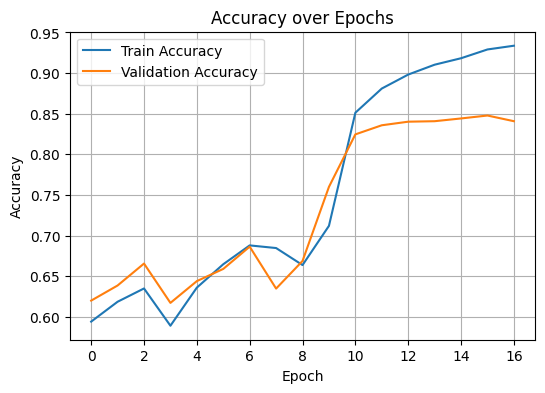


=== ALL EVALUATION ===
Accuracy: 0.8736
              precision    recall  f1-score   support

           0     0.8655    0.8846    0.8749     10000
           1     0.8820    0.8625    0.8721     10000

    accuracy                         0.8736     20000
   macro avg     0.8737    0.8736    0.8735     20000
weighted avg     0.8737    0.8736    0.8735     20000


=== ALL MODEL ===
Accuracy: 0.8736


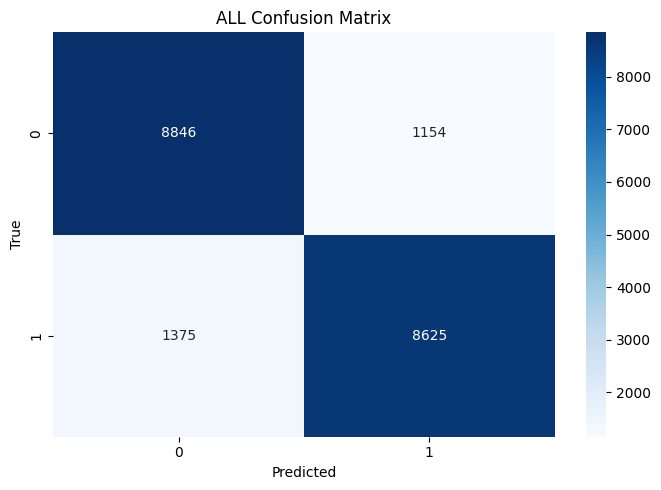

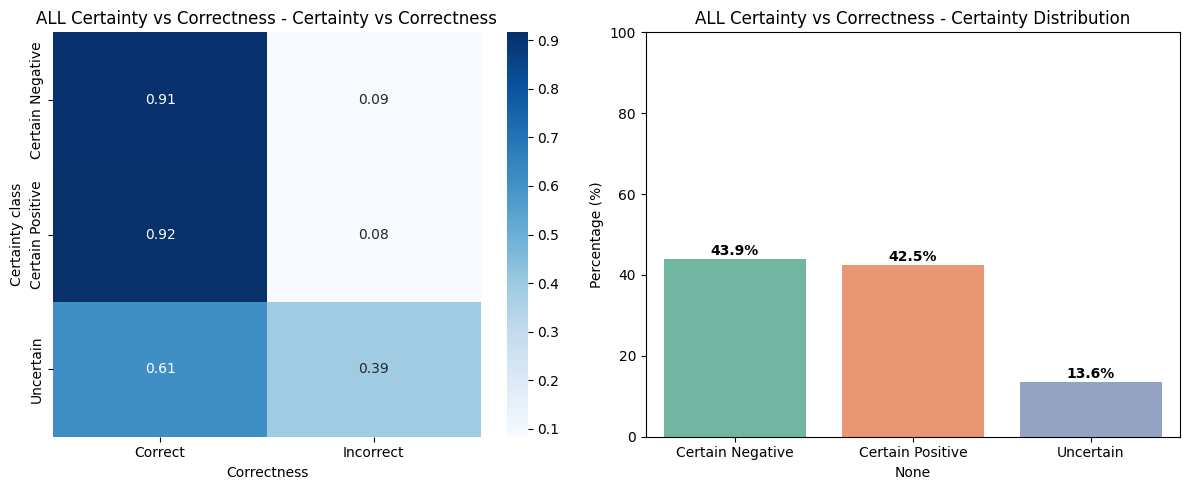


ALL MODEL - Unsure Predictions (probability near 0.3-0.7):
Probability [0.69], Label [1]: "The movie is absolutely silly.<br /><br />But were you expecting a high-brow intellectual film based on a comic called Slam Dunk? Really? Jay Chou's acting isn't exactly the most moving thing I've ever seen, but I certainly enjoyed the movie. Was it somewhere near the level of awesome that someone like Jet Li or Stephen Chow can produce? No, not really. Was it thoroughly entertaining if you're just taking it at surface value? Absolutely. It's a movie about some Chinese eye-candy idols and musicians who can play basketball at an unreal level of expertise. There's an evil Triad-style dude and a wacky scheming guy who gets Jay Chou involved in all of this. A love interest. It's formulaic but really, suspend disbelief for a while. Come on. It's called Kung Fu Dunk. What do you really think you signed on for? Do yourself a favor if you watch it - I found myself a copy with some Engrish subtitles that

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 71, 32)         │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 328,865 (1.25 MB)

 Trainable params: 328,865 (1.25 MB)

 Non-trainable params: 0 (0.00 B)


Training LSTM Model 'pos'...
Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.6809 - loss: 0.6150 - precision: 0.6911 - recall: 0.6506 - val_accuracy: 0.7768 - val_loss: 0.5052 - val_precision: 0.8038 - val_recall: 0.7396 - learning_rate: 0.0010
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.7707 - loss: 0.5136 - precision: 0.7929 - recall: 0.7309 - val_accuracy: 0.7812 - val_loss: 0.4939 - val_precision: 0.7941 - val_recall: 0.7665 - learning_rate: 0.0010
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.7882 - loss: 0.4852 - precision: 0.8105 - recall: 0.7505 - val_accuracy: 0.7782 - val_loss: 0.4900 - val_precision: 0.8013 - val_recall: 0.7471 - learning_rate: 0.0010
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.7976 - loss: 0.4678 - precision: 0.8215 - recall: 0.7589 - val_accuracy: 0.7682 - val_loss: 0.4991 - val_precision: 0.8096 - val_recall: 0.7088 - learning_rate: 0.0010
Epoch 5/20
313/313 ━━━━━━━━━━

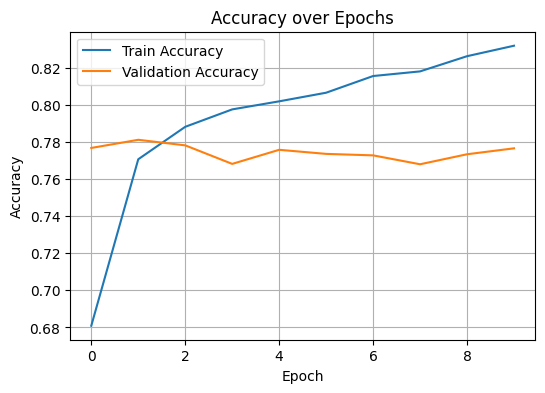


=== POS EVALUATION ===
Accuracy: 0.7884
              precision    recall  f1-score   support

           0     0.8221    0.7362    0.7768     10000
           1     0.7612    0.8407    0.7990     10000

    accuracy                         0.7884     20000
   macro avg     0.7916    0.7884    0.7879     20000
weighted avg     0.7916    0.7884    0.7879     20000


=== POS MODEL ===
Accuracy: 0.7884


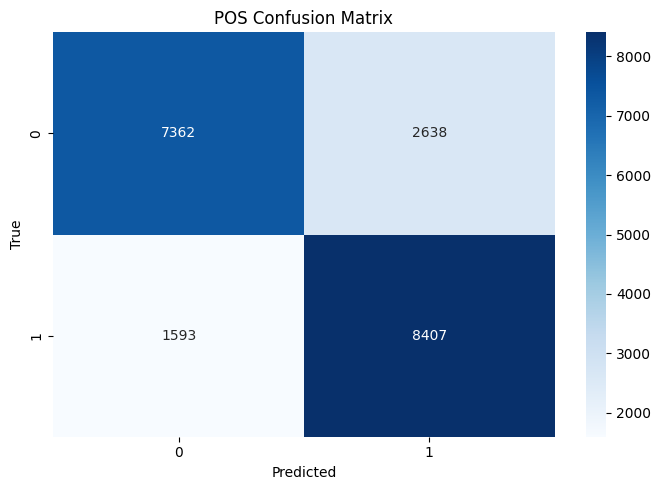

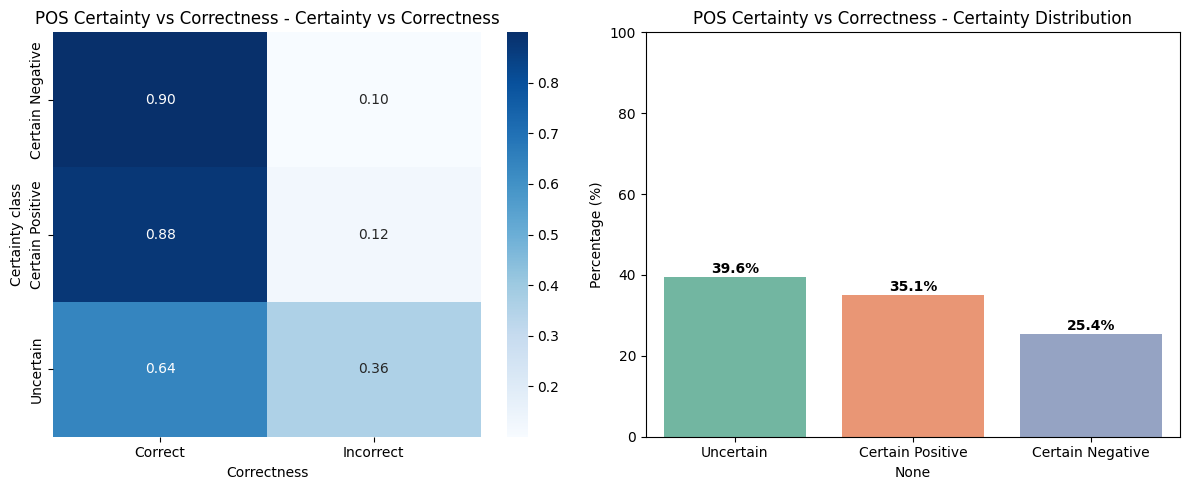


POS MODEL - Unsure Predictions (probability near 0.3-0.7):
Probability [0.57], Label [1]: "Brilliant movie. The drawings were just amazing. Too bad it ended before it begun. I´ve waited 21 years for a sequel, but nooooo!!!"
Probability [0.65], Label [1]: "I've seen tons of HK actioners, and this one is right at the top of the genre. The action scenes are as exciting and kinetic as anything you've ever seen in any action movie. The kung fu is spectacular, the pyrotechnics eye-popping, the stunt work heartstopping. The editing is perfectly paced, heightening the tension and complimenting the fluid camera work. This film is directed by old pro Corey Yuen, whose resume is stuffed with some of the best work of the genre, including the Jet Li vehicle The Legend of Fong Sai-Yuk. If there is one thing lacking in this film it is the presence of a three-dimensional character, though Martin, the male lead, comes closest to it. This movie is full of archetypes rather than characters--the sexy kil

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 84, 32)         │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 328,865 (1.25 MB)

 Trainable params: 328,865 (1.25 MB)

 Non-trainable params: 0 (0.00 B)


Training LSTM Model 'neg'...
Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6981 - loss: 0.5977 - precision: 0.6865 - recall: 0.7256 - val_accuracy: 0.7856 - val_loss: 0.4869 - val_precision: 0.7486 - val_recall: 0.8680 - learning_rate: 0.0010
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.8027 - loss: 0.4695 - precision: 0.7805 - recall: 0.8407 - val_accuracy: 0.8040 - val_loss: 0.4437 - val_precision: 0.7838 - val_recall: 0.8463 - learning_rate: 0.0010
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.8204 - loss: 0.4372 - precision: 0.7998 - recall: 0.8532 - val_accuracy: 0.8090 - val_loss: 0.4338 - val_precision: 0.7925 - val_recall: 0.8435 - learning_rate: 0.0010
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8283 - loss: 0.4219 - precision: 0.8084 - recall: 0.8592 - val_accuracy: 0.8068 - val_loss: 0.4383 - val_precision: 0.8006 - val_recall: 0.8234 - learning_rate: 0.0010
Epoch 5/20
313/313 ━━━━━━━━━

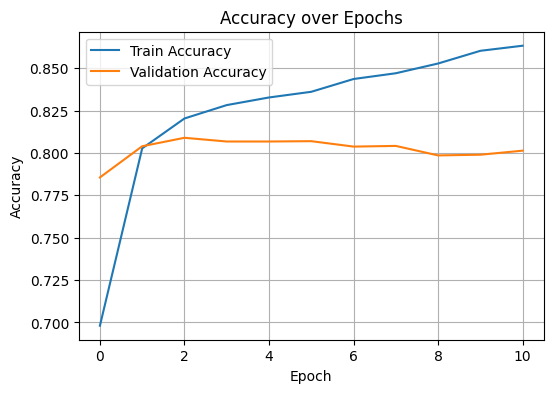


=== NEG EVALUATION ===
Accuracy: 0.8078
              precision    recall  f1-score   support

           0     0.8272    0.7783    0.8020     10000
           1     0.7907    0.8374    0.8134     10000

    accuracy                         0.8078     20000
   macro avg     0.8089    0.8078    0.8077     20000
weighted avg     0.8089    0.8078    0.8077     20000


=== NEG MODEL ===
Accuracy: 0.8078


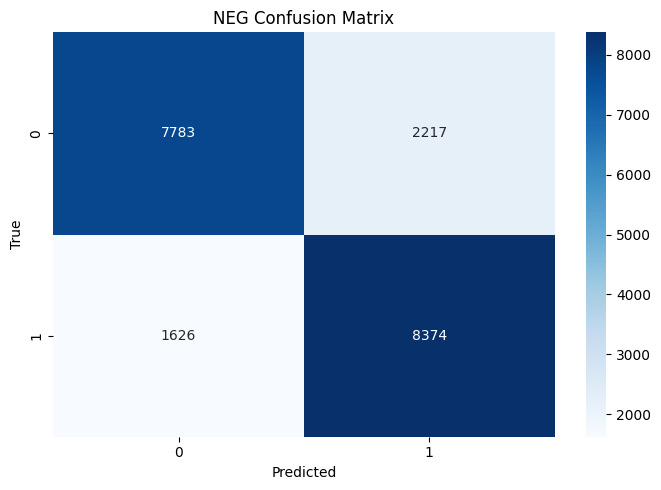

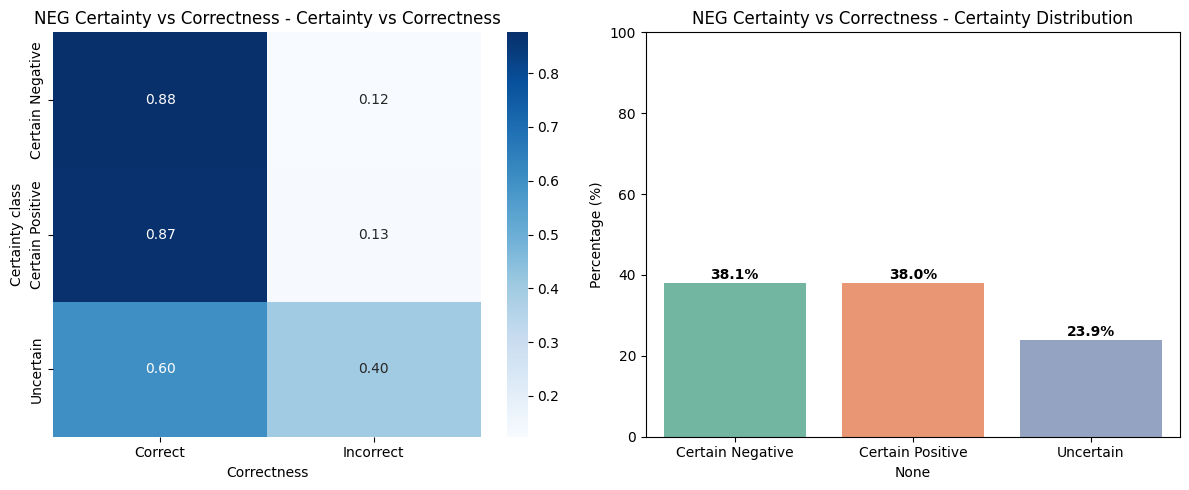


NEG MODEL - Unsure Predictions (probability near 0.3-0.7):
Probability [0.48], Label [1]: "I have no idea how to describe this movie, and also would love to provide others the same opportunity I had - seeing it with no prior knowledge of what to expect. I enjoyed it immensely but can also say I barely understood what was going on, if in fact there was anything to understand in the first place. Fans of David Lynch (tangentially) or especially Guy Maddin films should particularly enjoy this, and any fans of the comic book EIGHTBALL will probably be beside themselves with joy and wonder (it came as close as any film I've seen to the tone and mood Dan Clowes creates so effectively).<br /><br />One slight note just to warn anyone easily offended - this movie, if rated, would be NC-17 for sure. Fans of male full-frontal nudity, however...hmm, well...yes. This is weird wild stuff."
Probability [0.66], Label [1]: "I avoided watching this film for the longest time. Long before it was even rele

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 153, 32)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 328,865 (1.25 MB)

 Trainable params: 328,865 (1.25 MB)

 Non-trainable params: 0 (0.00 B)


Training LSTM Model 'important'...
Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - accuracy: 0.5454 - loss: 0.6909 - precision: 0.5368 - recall: 0.6418 - val_accuracy: 0.5518 - val_loss: 0.6880 - val_precision: 0.5309 - val_recall: 0.9838 - learning_rate: 0.0010
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6054 - loss: 0.6620 - precision: 0.5945 - recall: 0.6556 - val_accuracy: 0.7444 - val_loss: 0.5614 - val_precision: 0.8359 - val_recall: 0.6160 - learning_rate: 0.0010
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.5735 - loss: 0.6757 - precision: 0.5787 - recall: 0.5313 - val_accuracy: 0.6040 - val_loss: 0.6681 - val_precision: 0.5861 - val_recall: 0.7408 - learning_rate: 0.0010
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.5885 - loss: 0.6766 - precision: 0.5557 - recall: 0.8709 - val_accuracy: 0.5076 - val_loss: 0.6973 - val_precision: 0.5069 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 5/20
313/313 ━━━━

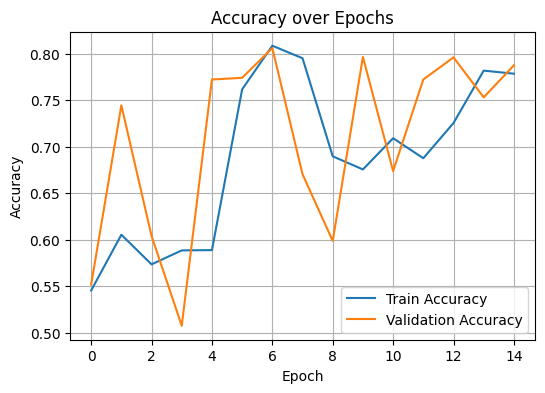


=== IMPORTANT EVALUATION ===
Accuracy: 0.8045
              precision    recall  f1-score   support

           0     0.8581    0.7298    0.7888     10000
           1     0.7649    0.8793    0.8181     10000

    accuracy                         0.8045     20000
   macro avg     0.8115    0.8045    0.8035     20000
weighted avg     0.8115    0.8045    0.8035     20000


=== IMPORTANT MODEL ===
Accuracy: 0.8045


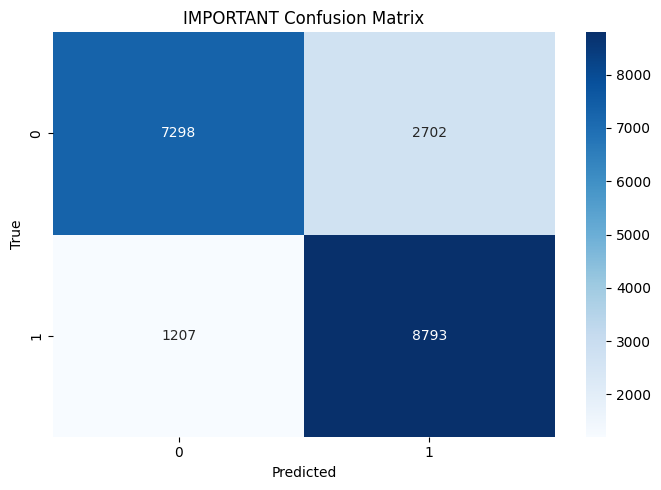

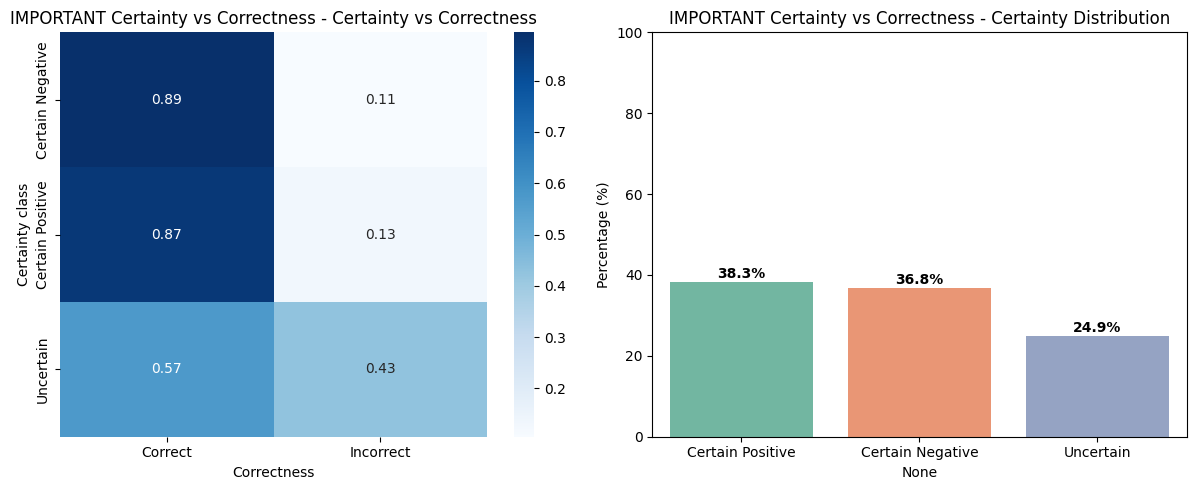


IMPORTANT MODEL - Unsure Predictions (probability near 0.3-0.7):
Probability [0.49], Label [0]: "As others have mentioned, this movie is similar to THE FLY (both versions) and the lesser known sci-fi flick ALTERED STATES. The big difference is that those two movies were well made by people who knew what they were doing and were good at it. METAMORPHOSIS did not have these advantages. METAMORPHOSIS is a potentially interesting science fantasy story that had the wrong people in charge of it and the wrong actors playing the roles.<br /><br />The story follows scientist Dr. Peter Houseman (Gene LeBrock), an obsessed man working on a genetic cure to aging and death. When the university he works for threatens to cut funding, he decides to inject the anti-aging serum into himself. As a result, Dr. Houseman spends the rest of the movie slowly turning into a lizard. And oh yes, watching the good doctor go through the process of becoming that lizard is a great joy. It really is so bad that it's

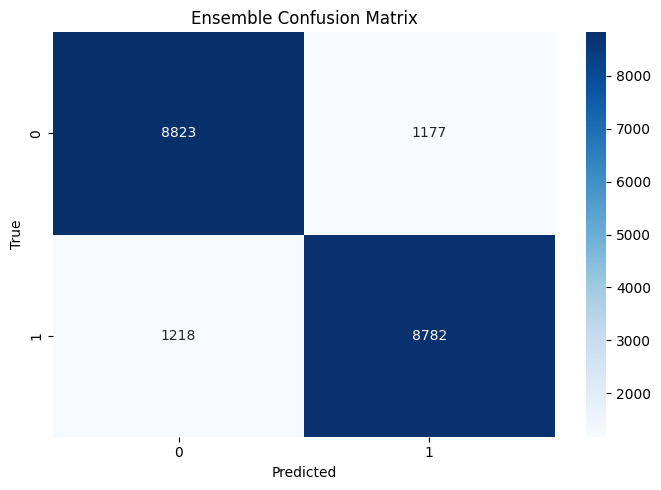

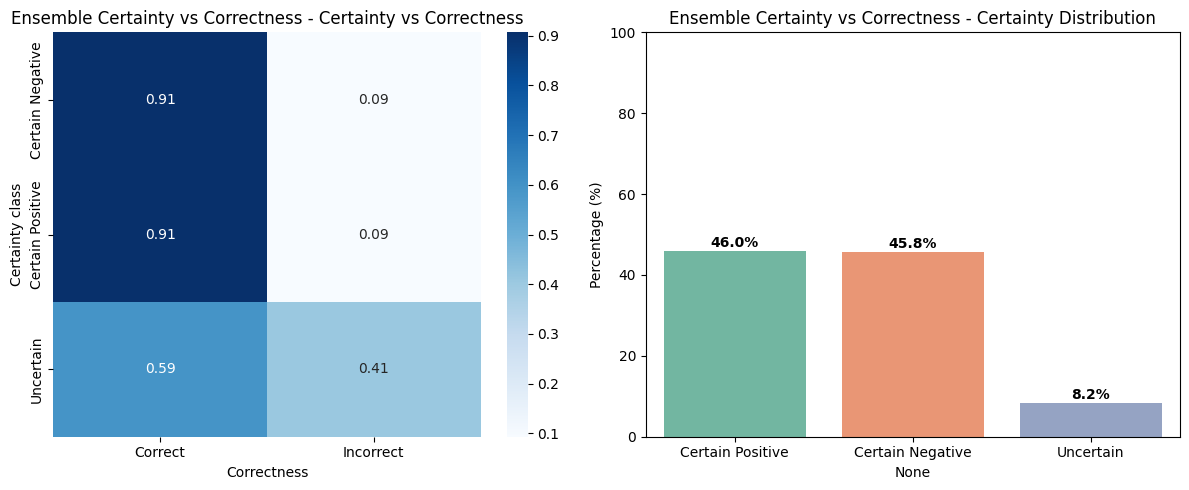


ENSEMBLE - Unsure Predictions (probability near 0.3-0.7):
Probability [0.40], Label [0]: "This movie forever left an impression on me. I watched it as a Freshman in High School and was home alone that night. I think I lost all respect for Robert Reed as an actor having been a huge fan of the "Brady Bunch". I also thought the role of Chuck Connor was horrendous and evil. However, this movie made such an impact on me that I am now a volunteer in the women's state prison doing bible studies and church services and trying to change womens lives, one at a time. What fascinates me is that so few people actually watched this movie. None of my friends watched it and my family is clueless to this day when I discuss this movie because they didn't see it."
Probability [0.32], Label [1]: "I liked Top Gun. It held my interest. Predictable plot, decent character development and story line. It is pretty similar to High Noon in that the town people appear weak and scared to stand up to a villain. Thi

In [15]:
results = run_experiment(X_sets_train, y_train, X_sets_test, y_test, test_df["review"], "lstm", num_concepts, sequence_lengths)